# トレーニングデータのインポート & チェック

In [4]:
# import needed file
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


In [5]:
# import data
transforms = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)


In [6]:
print(trainset.data.shape)
(50000, 32, 32, 3)

# テスト用データセット：縦横32ピクセルのRGBの画像が10000枚
print(testset.data.shape)
(10000, 32, 32, 3)

# クラス一覧を確認する
print(trainset.classes)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# classesはよく利用するので別途保持しておく
classes = trainset.classes

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 36, 138)
(36, 138, 3)


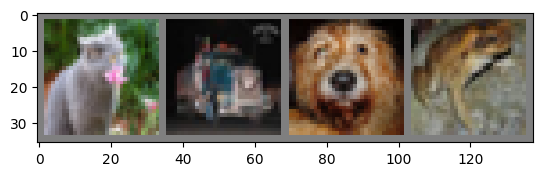

  cat truck   dog  frog


In [7]:
def imshow(img):
    # 非正規化する
    img = img / 2 + 0.5
    # torch.Tensor型からnumpy.ndarray型に変換する
    print(type(img)) # <class 'torch.Tensor'>
    npimg = img.numpy()
    print(type(npimg))    
    # 形状を（RGB、縦、横）から（縦、横、RGB）に変換する
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    # 画像を表示する
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
# 別ファイルのimport
import cnn
import vit

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn_net = cnn.Net(
    class_num=10,
    conv_size=[3,6,16],
    linear_size=[120,84]
)
vit_net = vit.Net(
    image_size=32,
    patch_size=4,
    n_classes=10,
    dim=256,
    depth=3,
    n_heads=4,
    mlp_dim=256,
)

# 損失関数
criterion = nn.CrossEntropyLoss()
# CNNオプティマイザの設定
optimizer_cnn = torch.optim.SGD(cnn_net.parameters(),lr = 0.001, momentum=0.9)
optimizer_vit = torch.optim.SGD(vit_net.parameters(),lr = 0.001, momentum=0.9)

In [10]:
print(cnn_net)
print(vit_net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)
Net(
  (patching): Patching(
    (net): Rearrange('b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=4, pw=4)
  )
  (linear_projection_of_flattened_patches): LinearProjection(
    (net): Linear(in_features=48, out_features=256, bias=True)
  )
  (embedding): Embedding()
  (transformer_encoder): TransformerEncoder(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (multi_head_attention): MultiHeadAttention(
      (W_q): Linear(in_features=256, out_features=256, bias=True)
      (W_k): Linear(in_features=256, out_features=256, bias=True)
      (W_v): Linear(in_features=25

# ViTでの学習

In [11]:

# トレーニングする
for epoch in range(2):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_vit.zero_grad()
        outputs = vit_net(inputs)
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward()
        optimizer_vit.step()
        train_loss = loss.item()
        running_loss += loss.item()/len(trainloader)
        train_acc = (outputs.argmax(dim=1) == labels).float().mean()
        running_acc += train_acc/len(trainloader)

        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f , acc:%.3f' % (epoch + 1, i + 1, running_loss, running_acc))
            running_loss = 0.0
print('Finished Training')

KeyboardInterrupt: 

# CNNでの学習

In [12]:
# トレーニングする
for epoch in range(2):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_cnn.zero_grad()
        outputs = cnn_net(inputs)
        # 損失の計算
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward()
        optimizer_cnn.step()
        # 損失と精度の計算
        train_loss = loss.item()
        running_loss += train_loss / len(trainloader)
        # 精度の計算
        train_acc = (outputs.argmax(dim=1) == labels).float().mean()
        running_acc += train_acc.item() / len(trainloader)
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1, running_loss, running_acc))
            running_loss = 0.0
            running_acc = 0.0  
print('Finished Training')


[1,  2000] loss: 0.352 acc: 0.028
[1,  4000] loss: 0.304 acc: 0.048
[1,  6000] loss: 0.275 acc: 0.058
[1,  8000] loss: 0.258 acc: 0.065
[1, 10000] loss: 0.245 acc: 0.071
[1, 12000] loss: 0.236 acc: 0.074
[2,  2000] loss: 0.226 acc: 0.078
[2,  4000] loss: 0.220 acc: 0.080
[2,  6000] loss: 0.220 acc: 0.081
[2,  8000] loss: 0.212 acc: 0.084
[2, 10000] loss: 0.207 acc: 0.085
[2, 12000] loss: 0.204 acc: 0.086
Finished Training


In [14]:
Path = './cifar_net.pth'
torch.save(cnn_net.state_dict(),Path)
torch.save(vit_net.state_dict().Path)

AttributeError: 'collections.OrderedDict' object has no attribute 'Path'

# 比較